# **PCA(Principle Component Analysis)를 이용한 Odor 분석**

---

In [ ]:
import rpy2
%load_ext rpy2.ipython

In [ ]:
%%R
package_version(R.version)

[1] ‘4.1.0’


In [ ]:
%%R

.libPaths("/content/drive/MyDrive/R packages")
.libPaths()

[1] "/content/drive/MyDrive/R packages" "/usr/local/lib/R/site-library"    
[3] "/usr/lib/R/site-library"           "/usr/lib/R/library"               


## **0. Packages Installation**

In [ ]:
%%R

# install.packages("corrplot")                  
# install.packages("PerformanceAnalytics")      # 상관분석 시각화
# install.packages("caret")      
# install.packages("car")            # 다중공산성   
# install.packages("ISLR")
# install.packages("pls")            # pcr 함수
# install.packages("mice")           # M.I 결측치 대체
# install.packages("stringr")
# install.packages("Metrics")        # RMSE, MAPE
# install.packages("factoextra")     # Loadings Plot
# install.packages("DAAG")           # cv.lm
# install.packages("lmtest")         # Durbin-Watson test (잔차의 독립성)

library(lmtest)
library(DAAG)
library(factoextra)
library(Metrics)
library(mice)
library(stringr)
library(pls)
library(ISLR)    
library(corrplot)
library(PerformanceAnalytics)
library(caret)
library(car)

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: ggplot2

R[write to console]: Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

R[write to console]: 
Attaching package: ‘mice’


R[write to console]: The following object is masked from ‘package:stats’:

    filter


R[write to console]: The following objects are masked from ‘package:base’:

    cbind, rbind


R[write to console]: 
Attaching package: ‘pls’


R[write to console]: The following object is masked from ‘package:stats’:

    loadings


R[write to console]: corrplot 0.84 loaded

R[write to console]: 
Attaching package: ‘corrplot’


R[write to console]: The following object is masked from ‘package:pls’:

    corrplot


R[write to con

## **1. Data Preparation**

### **1) Read preprocessed data (log_odo)**

In [ ]:
%%R

odo <- read.csv("drive/MyDrive/PLS_양돈 농가/New_data_preprocessed.csv", fileEncoding = "euc-kr")

### Log + Scaling
log_odo <- as.data.frame(scale(log(odo), center = T, scale = T))
head(log_odo)

          ou       nh3        h2s       mm.1        dms        aca        ppa
1 -1.2249600 -2.043309 -0.3600950 -0.6331603  1.4587731 -1.0749493 -1.4207491
2 -1.2249600 -1.936882  0.3387812  1.0552224  2.8066385  0.7668098  0.9990535
3 -0.8209050 -1.468885 -0.7936594 -0.8879723  2.0631026  0.5917261  0.7867864
4  0.7260806 -1.416330  0.4345010 -0.8879723  1.4646004  0.4284440  0.6354347
5 -1.1919213 -1.263970  0.3446961 -0.8879723 -0.7092863  0.3237269  0.5183596
6 -0.4168700 -1.458160 -1.1504747 -0.8879723 -0.7092863  0.2447109  0.3430590
         iba        bta        iva        vla          ph         pc
1 -1.7334805 -1.6740815 -1.8596790 -1.3374486 -0.64265976 -4.7612230
2  1.2984638  1.1289898  1.3516990  1.2950587  1.08960883  0.8397641
3  0.9772720  1.0331016  1.0695726  1.1290003  0.55236433  0.3658753
4  0.6718374  0.9381735  0.8924571  0.7198563  0.19073125  0.2936154
5  0.5326620  0.7975387  0.8428153  0.6331179  0.21571194  0.3888851
6  0.3998548  0.8066882  0.6910340  0.60

### **2) Data Visualizations**

#### **- 반응변수 (y)**

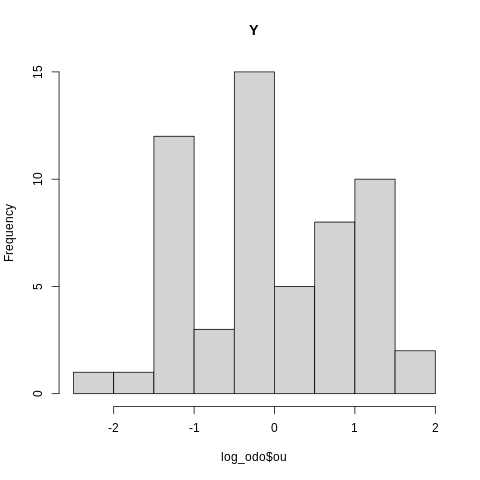

In [ ]:
%%R

hist(log_odo$ou, main="Y")

#### **- Correlation Plot (hitmap)**

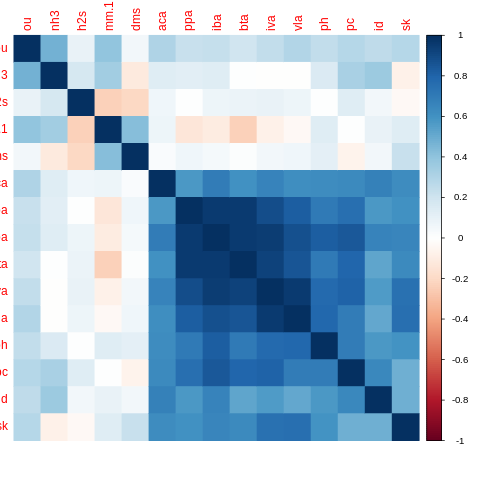

In [ ]:
%%R

log_res <- cor(log_odo, method = "pearson")
corrplot::corrplot(log_res, method = "color", order = "original", tl.pos = "r")


#### **- Correlation Plot**

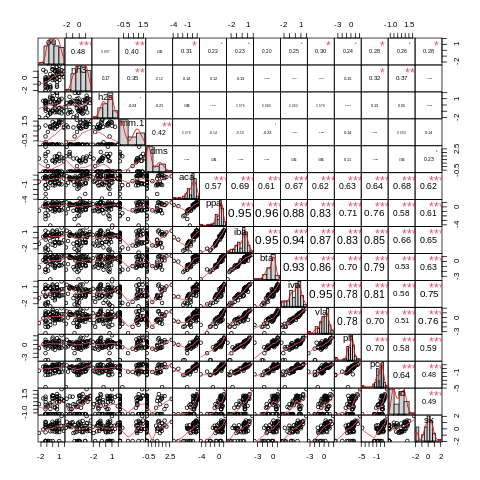

In [ ]:
%%R

chart.Correlation(log_odo, histogram = T, pch = 5)

#### **- Correlation Values**

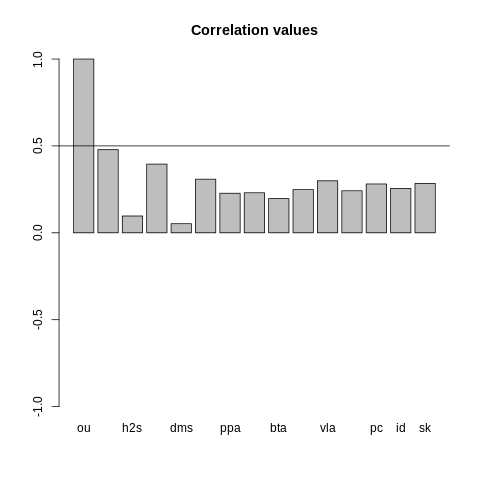

In [ ]:
%%R

# 반응변수
barplot(log_res["ou",], ylim = c(-1,1), main = "Correlation values") ; abline(h = 0.5)

# Total
# print(log_res)

### **3) 다중 공선성 확인**

In [ ]:
%%R

log_mr <- lm(ou ~ ., data = log_odo)

log_VIF <- vif(log_mr)
print(log_VIF)

      nh3       h2s      mm.1       dms       aca       ppa       iba       bta 
 2.590253  1.394278  2.592621  1.538076  2.940215 31.452120 71.838164 33.268410 
      iva       vla        ph        pc        id        sk 
52.146947 19.397979  6.730872  6.965551  3.131767  3.521264 



 5 개 : aca ppa iba bta iva

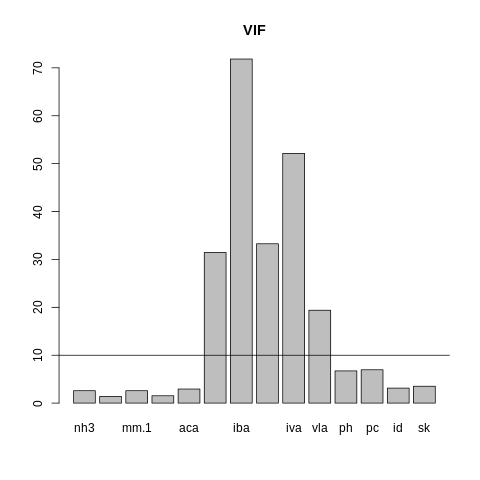

In [ ]:
%%R

barplot(log_VIF, main = "VIF")
abline(h = 10)

cat("\n", sum(log_VIF > 10), "개 :", names(odo[log_VIF > 10]))

## **2. Log + PCA**

### **1) PCA 분석 (odop)**

In [ ]:
%%R

odop <- prcomp(log_odo[,2 : ncol(log_odo)],  center = T)

odop

Standard deviations (1, .., p=14):
 [1] 2.74892071 1.31695005 1.22311204 0.90457107 0.80918118 0.73329872
 [7] 0.59735284 0.53141922 0.47258135 0.41086688 0.34435751 0.15144893
[13] 0.14444208 0.09252296

Rotation (n x k) = (14 x 14):
              PC1         PC2          PC3         PC4         PC5         PC6
nh3   0.053102051 -0.21009134  0.706777455  0.11599799  0.28137971  0.01988517
h2s   0.028612167  0.35130753  0.362680323 -0.83799809  0.02187285  0.04734027
mm.1 -0.007581931 -0.67490304  0.153187184 -0.09091212  0.01434414  0.43964956
dms   0.024993012 -0.51715179 -0.323992949 -0.42653855  0.32904496 -0.51127289
aca   0.278675502 -0.08661018  0.099129730 -0.02694420 -0.60867457 -0.13420059
ppa   0.333152900  0.07767252 -0.063434926  0.12859306  0.30309864 -0.11776730
iba   0.355302140  0.06235166 -0.007942873  0.05921398  0.14959396 -0.06945453
bta   0.337550845  0.16289641 -0.113082076  0.03753501  0.22431331 -0.06430748
iva   0.349770603  0.06698604 -0.116175219 -0.05532910

### **2) 최적의 PCA 개수 선택 (ocomp)**

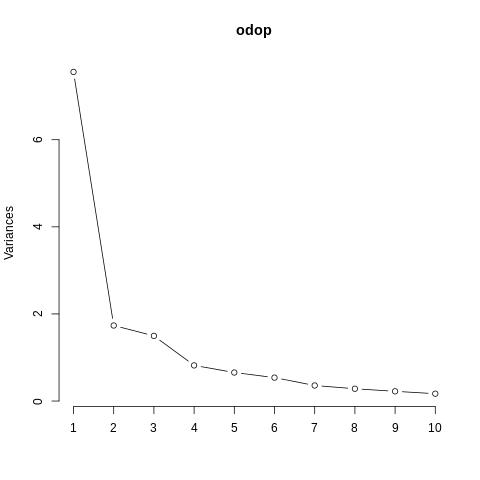

In [ ]:
%%R

plot(odop, type="l")

In [ ]:
%%R

### 누적 설명력이 85이 넘는 첫 PC 위치
ocomp <- which(summary(odop)$importance[3,] > 0.85)[1] 
ocomp               

PC5 
  5 


### **3) New dataset**

In [ ]:
%%R

pc_x <- as.matrix(log_odo[, 2:ncol(log_odo)]) %*% as.matrix(odop$rotation)
head(pc_x)

            PC1        PC2       PC3        PC4        PC5        PC6
[1,] -5.0593768 -0.5453653 -2.963410 -1.2729998 -1.1413075 -0.6123076
[2,]  3.3990958 -1.6286980 -2.261544 -1.7999313  0.3104919 -0.7901360
[3,]  2.2044067 -0.1920240 -2.544499 -0.3108546  0.5811219 -1.0929544
[4,]  2.1151003  0.2685628 -1.553404 -1.0781644 -0.2480881 -1.4537297
[5,]  1.2208645  1.6543745 -1.340849 -0.2098386 -0.0510329  0.8907629
[6,]  0.8198263  1.1830119 -2.009846  1.0056236 -0.1619172  0.7544544
             PC7        PC8        PC9       PC10        PC11        PC12
[1,] -0.42308041  1.9701380 -1.4914560 -1.0051925  0.39697015 -0.26673461
[2,]  0.85247225 -0.1836416  0.8474931 -0.2952087 -0.01000183  0.06941375
[3,]  0.48688285 -0.2578760 -0.3267627  0.2317394 -0.58735904 -0.06093448
[4,] -0.06088333  0.2420431  0.5191232  0.0316776 -0.14264304 -0.05993434
[5,]  0.13773079 -0.5874246 -0.1683698  0.1245358  0.20976413 -0.02144899
[6,]  0.05045847 -0.5951030 -0.1969310  0.1622007 -0.02768277 -0.1

#### **- All Comp (odopa)**

In [ ]:
%%R

odopa <- cbind(log_odo["ou"], pc_x)

head(odopa)

          ou        PC1        PC2       PC3        PC4        PC5        PC6
1 -1.2249600 -5.0593768 -0.5453653 -2.963410 -1.2729998 -1.1413075 -0.6123076
2 -1.2249600  3.3990958 -1.6286980 -2.261544 -1.7999313  0.3104919 -0.7901360
3 -0.8209050  2.2044067 -0.1920240 -2.544499 -0.3108546  0.5811219 -1.0929544
4  0.7260806  2.1151003  0.2685628 -1.553404 -1.0781644 -0.2480881 -1.4537297
5 -1.1919213  1.2208645  1.6543745 -1.340849 -0.2098386 -0.0510329  0.8907629
6 -0.4168700  0.8198263  1.1830119 -2.009846  1.0056236 -0.1619172  0.7544544
          PC7        PC8        PC9       PC10        PC11        PC12
1 -0.42308041  1.9701380 -1.4914560 -1.0051925  0.39697015 -0.26673461
2  0.85247225 -0.1836416  0.8474931 -0.2952087 -0.01000183  0.06941375
3  0.48688285 -0.2578760 -0.3267627  0.2317394 -0.58735904 -0.06093448
4 -0.06088333  0.2420431  0.5191232  0.0316776 -0.14264304 -0.05993434
5  0.13773079 -0.5874246 -0.1683698  0.1245358  0.20976413 -0.02144899
6  0.05045847 -0.5951030 -0.

#### **- Best Comp (odopb)**

In [ ]:
%%R

odopb <- cbind(log_odo["ou"], pc_x[,1:ocomp])

head(odopb)

          ou        PC1        PC2       PC3        PC4        PC5
1 -1.2249600 -5.0593768 -0.5453653 -2.963410 -1.2729998 -1.1413075
2 -1.2249600  3.3990958 -1.6286980 -2.261544 -1.7999313  0.3104919
3 -0.8209050  2.2044067 -0.1920240 -2.544499 -0.3108546  0.5811219
4  0.7260806  2.1151003  0.2685628 -1.553404 -1.0781644 -0.2480881
5 -1.1919213  1.2208645  1.6543745 -1.340849 -0.2098386 -0.0510329
6 -0.4168700  0.8198263  1.1830119 -2.009846  1.0056236 -0.1619172


### **4) Plots**

#### **- Correlation Plot**

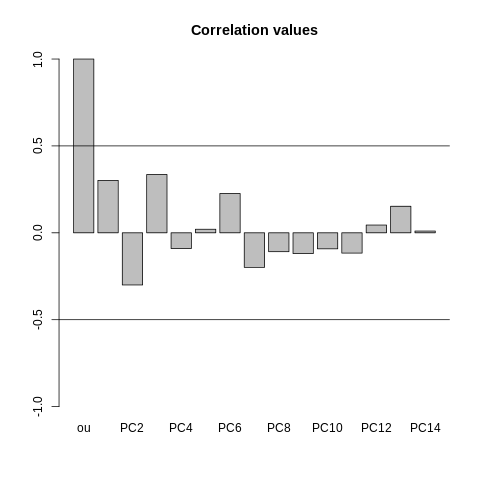

In [ ]:
%%R

resp <- cor(odopa, method = "pearson")

# 반응변수
barplot(resp["ou",], ylim = c(-1, 1), main = "Correlation values") ; abline(h = c(0.5, -0.5))

# Total
# print(resp)

##### **- Correlation Plot (hitmap)**

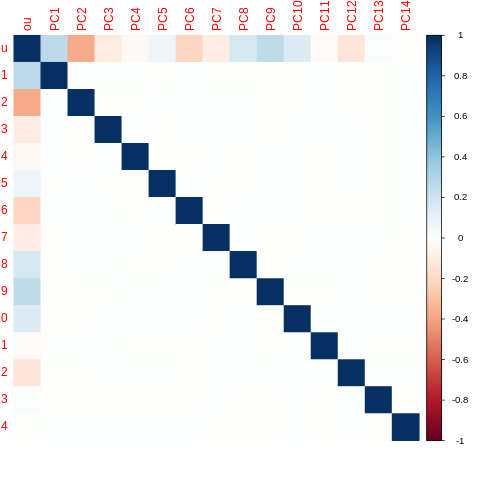

In [ ]:
%%R

corrplot::corrplot(resp, method = "color", order = "original", tl.pos = "r")


##### **- Correlation Plot**

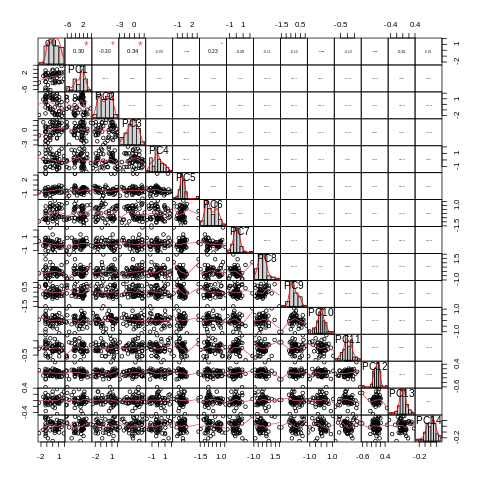

In [ ]:
%%R

chart.Correlation(odopa, histogram = T, pch = 5)

#### **- Importance**

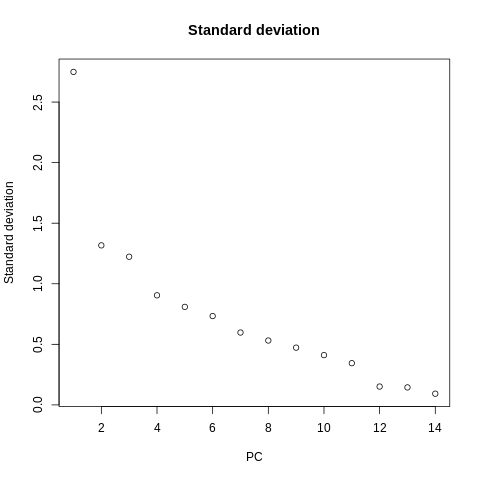

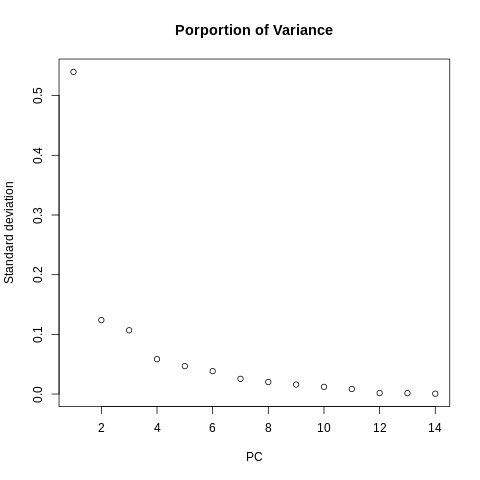

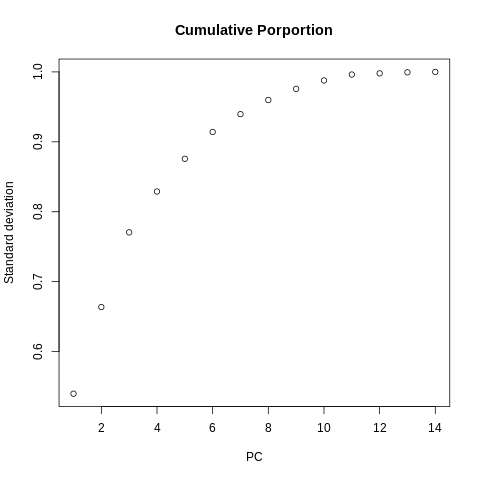

In [ ]:
%%R
summary(odop)$importance
plot(summary(odop)$importance[1,], main = "Standard deviation", xlab = "PC", ylab = "Standard deviation")
plot(summary(odop)$importance[2,], main = "Porportion of Variance", xlab = "PC", ylab = "Standard deviation")
plot(summary(odop)$importance[3,], main = "Cumulative Porportion", xlab = "PC", ylab = "Standard deviation")

#### **- Loading Plot**

##### **- Variables plot**

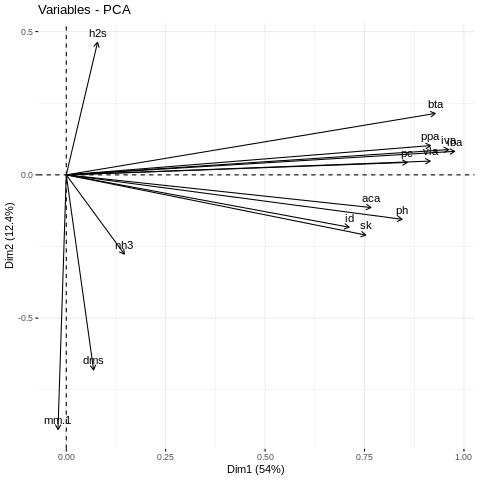

In [ ]:
%%R

fviz_pca_var(odop, axes = c(1, 2))

##### **- Biplot**

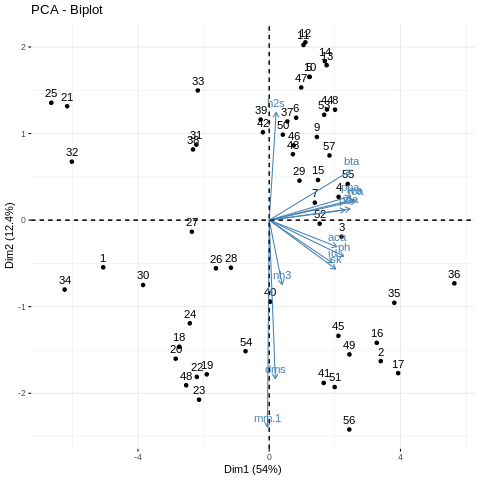

In [ ]:
%%R

fviz_pca_biplot(odop, axes = c(1, 2))

## **3. PCAR**

### **1) All Components (pcaa)**

In [ ]:
%%R

pcaa <- lm(ou ~ ., data = odopa)
summary(pcaa)


Call:
lm(formula = ou ~ ., data = odopa)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.82846 -0.45261  0.00082  0.43087  1.90520 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -2.231e-16  1.117e-01   0.000   1.0000   
PC1          1.098e-01  4.099e-02   2.678   0.0105 * 
PC2         -2.281e-01  8.555e-02  -2.666   0.0109 * 
PC3          2.743e-01  9.212e-02   2.978   0.0048 **
PC4         -1.000e-01  1.246e-01  -0.803   0.4265   
PC5          2.542e-02  1.392e-01   0.183   0.8560   
PC6          3.086e-01  1.536e-01   2.009   0.0510 . 
PC7         -3.329e-01  1.886e-01  -1.765   0.0849 . 
PC8         -2.047e-01  2.120e-01  -0.965   0.3399   
PC9         -2.526e-01  2.384e-01  -1.059   0.2955   
PC10        -2.244e-01  2.742e-01  -0.818   0.4178   
PC11        -3.394e-01  3.272e-01  -1.037   0.3055   
PC12         2.956e-01  7.439e-01   0.397   0.6931   
PC13         1.057e+00  7.800e-01   1.355   0.1826   
PC14         1.107e-01  1.218

### **2) Best Components (pcab)**

In [ ]:
%%R

pcab <- lm(ou ~ ., data = odopb)
summary(pcab)


Call:
lm(formula = ou ~ ., data = odopb)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.09061 -0.59011 -0.03947  0.73849  1.68640 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -2.381e-16  1.159e-01   0.000  1.00000   
PC1          1.098e-01  4.255e-02   2.580  0.01281 * 
PC2         -2.281e-01  8.881e-02  -2.568  0.01320 * 
PC3          2.743e-01  9.562e-02   2.869  0.00598 **
PC4         -1.000e-01  1.293e-01  -0.774  0.44272   
PC5          2.542e-02  1.445e-01   0.176  0.86109   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8752 on 51 degrees of freedom
Multiple R-squared:  0.3024,	Adjusted R-squared:  0.234 
F-statistic: 4.422 on 5 and 51 DF,  p-value: 0.002019



#### **- 잔차 검정 (Best 기준)**

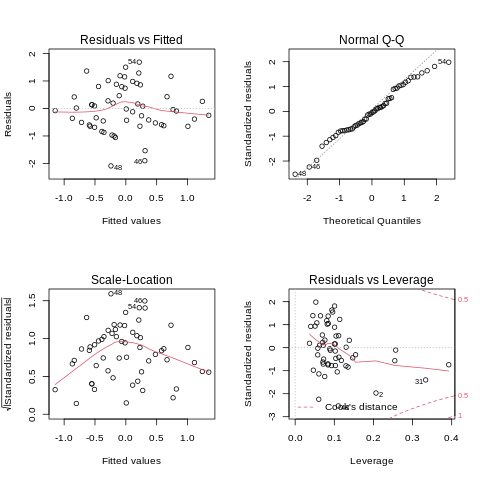

In [ ]:
%%R

par(mfrow=c(2,2))
plot(pcab)
par(mfrow=c(1,1))

##### **- 잔차의 등분산성 (Breusch-Pagan test)**

- $H_0$ : 등분산성이다.  vs  $H_1$ : 등분산성이 아니다.

In [ ]:
%%R

bptest(pcab)


	studentized Breusch-Pagan test

data:  pcab
BP = 3.2946, df = 5, p-value = 0.6547



##### **- 잔차의 독립성 (Durbin-Watson test)**

- $H_0$ : 잔차는 독립이다.  vs  $H_1$ : 잔차가 자기상관관계가 있다.

-  DW statistic 값이 2 근처의 값이 나오는 경우 자기상관관계가 없다. (= 독립)

In [ ]:
%%R

dwtest(pcab)


	Durbin-Watson test

data:  pcab
DW = 1.6998, p-value = 0.08953
alternative hypothesis: true autocorrelation is greater than 0



##### **- 잔차의 정규성 (Shapiro-test)**

- $H_0$ : 모집단은 정규분포를 따른다.   vs   $H_1$ : 모집단은 정규분포를 따르지 않는다.

In [ ]:
%%R

pcab_res <- residuals(pcab)
shapiro.test(pcab_res)


	Shapiro-Wilk normality test

data:  pcab_res
W = 0.9796, p-value = 0.4469



#### **- LOOCV PCAR (Best comp 기준)**

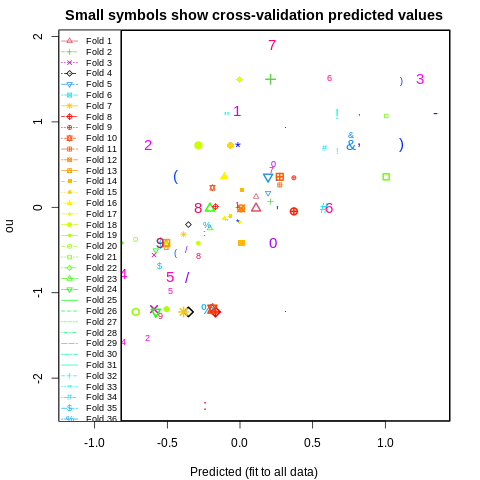

In [ ]:
%%%R

cv_pcab <- cv.lm(odopb, form.lm = ou ~ ., m = nrow(odopb), printit = F)

## **4. Results (Best comp + LOO 기준)**

### **1) Validation**

In [ ]:
%%R

cvlm_vp <- cv_pcab$cvpred

#### **- R-squared**

In [ ]:
%%R

### R-squared
y <- log_odo$ou

cvlm_r2 <- cor(y, cvlm_vp)^2

cat("R2 - CV lm : ", round(cvlm_r2, 4))

R2 - CV lm :  0.1604

#### **- RMSE**

\
- $RMSE = \sqrt{{1 \over n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In [ ]:
%%R

cvlm_rmse <- rmse(y, cvlm_vp)

cat("RMSE - CV lm : ", round(cvlm_rmse, 4))

RMSE - CV lm :  1.0061

#### **- MAPE**

\
- Mean Absolute Precentage Error

\
- $MAPE = {100 \over n} \sum_{t=1}^n |{A_t - F_t \over A_t}|$

  - $A_t$ : True Value
  - $F_t$ : Predicted Value

In [ ]:
%%R

cvlm_mape <- mape(cvlm_vp, y)

cat("MAPE - CV lm : ", round(cvlm_mape, 4))

MAPE - CV lm :  6.311

#### **- predicted plot**

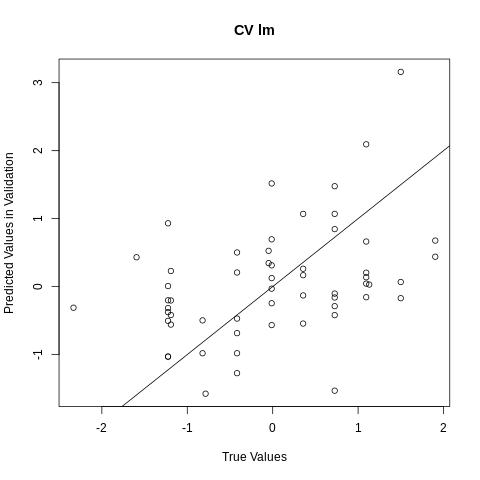

In [ ]:
%%R

plot(y, cvlm_vp,
     xlab = "True Values", ylab = "Predicted Values in Validation",
     main = "CV lm")
abline(a = 0 , b =1)

### **2) Fitted**

In [ ]:
%%R

cvlm_fp <- cv_pcab$Predicted

#### **- R-squared**

In [ ]:
%%R

### R-squared
y <- log_odo$ou

cvlm_fr2 <- cor(y, cvlm_fp)^2

cat("R2 - CV lm : ", round(cvlm_fr2, 4))

R2 - CV lm :  0.3024

#### **- RMSE**

\
- $RMSE = \sqrt{{1 \over n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In [ ]:
%%R

cvlm_frmse <- rmse(y, cvlm_fp)

cat("RMSE - CV lm : ", round(cvlm_frmse, 4))

RMSE - CV lm :  0.8279

#### **- MAPE**

\
- Mean Absolute Precentage Error

\
- $MAPE = {100 \over n} \sum_{t=1}^n |{A_t - F_t \over A_t}|$

  - $A_t$ : True Value
  - $F_t$ : Predicted Value

In [ ]:
%%R

cvlm_fmape <- mape(cvlm_fp, y)

cat("MAPE - CV lm : ", round(cvlm_fmape, 4))

MAPE - CV lm :  14.1059

#### **- predicted plot**

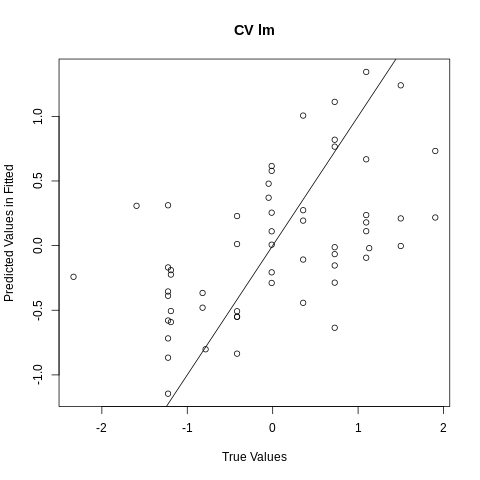

In [ ]:
%%R

plot(y, cvlm_fp,
     xlab = "True Values", ylab = "Predicted Values in Fitted",
     main = "CV lm")
abline(a = 0 , b =1)

### **3) 결과 정리**

In [ ]:
%%R

Log_pca_valid_results <- round(c(cvlm_r2, cvlm_rmse, cvlm_mape), 3)
Log_pca_valid_results <- t(as.data.frame(Log_pca_valid_results))
colnames(Log_pca_valid_results) <- c("R2", "RMSE", "MAPE")
rownames(Log_pca_valid_results) <- c("PCA")

Log_pca_valid_results

      R2  RMSE  MAPE
PCA 0.16 1.006 6.311


In [ ]:
%%R

Log_pca_fitted_results <- round(c(cvlm_fr2, cvlm_frmse, cvlm_fmape), 3)
Log_pca_fitted_results <- t(as.data.frame(Log_pca_fitted_results))
colnames(Log_pca_fitted_results) <- c("FR2", "FRMSE", "FMAPE")
rownames(Log_pca_fitted_results) <- c("PCA")

Log_pca_fitted_results

      FR2 FRMSE  FMAPE
PCA 0.302 0.828 14.106


In [ ]:
%%R

Results <- cbind(Log_pca_valid_results, Log_pca_fitted_results)
# Results

write.csv(Results, file = "drive/MyDrive/PLS_양돈 농가/(Results) Log_PCA.csv")

check_Results <- read.csv("drive/MyDrive/PLS_양돈 농가/(Results) Log_PCA.csv", fileEncoding = "euc-kr", row.names = 1)
check_Results

      R2  RMSE  MAPE   FR2 FRMSE  FMAPE
PCA 0.16 1.006 6.311 0.302 0.828 14.106
